In [1]:
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import os
import torch
from typing import List

from dataset import CLIPDataset, get_transforms, collate_fn
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer
from tqdm import tqdm
from clip import CLIPModel  # type: ignore
from train import wandb_config

config = wandb_config['config']
device = config['device']


def get_image_embeddings(image_names: List[str], model_path):
    dataset = CLIPDataset(image_filenames=image_names, captions=None,
                          tokenizer=None, max_length=None, transforms=get_transforms(mode='test', image_size=224))
    loader = DataLoader(dataset, batch_size=32,
                        shuffle=False, collate_fn=collate_fn)

    model = CLIPModel(
        text_model_name=config['text_encoder']['model_name'],
        image_model_name=config['image_encoder']['model_name'],
        text_pretrained=config['text_encoder']['pretrained'],
        text_trainable=config['text_encoder']['trainable'],
        image_pretrained=config['image_encoder']['pretrained'],
        image_trainable=config['image_encoder']['trainable'],
        text_embedding_dim=config['text_encoder']['embedding_dim'],
        image_embedding_dim=config['image_encoder']['embedding_dim'],
        projection_dim=config['projection_head']['embedding_dim'],
        temperature=config['train']['temperature']
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(loader):
            image = batch['image'].to(device)
            image_embeddings.append(model.get_image_features(image))
    return model, torch.cat(image_embeddings)


def find_matches(model, query, image_embeddings, image_filenames, size: tuple[int, int]):
    tokenizer: DistilBertTokenizer = DistilBertTokenizer.from_pretrained(
        config['text_encoder']['model_name'])
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = model.get_text_features(
            batch['input_ids'], batch['attention_mask']
        )

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    row, col = size
    n = row * col
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches_files = [image_filenames[idx] for idx in indices]

    _, axes = plt.subplots(row, col, figsize=(15, 8))
    print('query is: ', query)
    for idx, ax in zip(range(len(matches_files)), axes.flatten()):
        filename = matches_files[idx]
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ax 显示相似性得分
        ax.set_title(f'score: {values[idx]:.2f}')
        ax.imshow(image)
        ax.axis("off")

    plt.show()


def get_image_names(img_dir: str):
    return [os.path.join(img_dir, name) for name in os.listdir(img_dir) if name.endswith('.jpg') or name.endswith('.png')]

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
img_names = get_image_names('./datasets/children_and_adults/images/train')
query_list = [
    'a photo of dog',
    'a photo of cat, type of animal',
    'a photo of people laugh loudly',
    'a photo of people working in the office',
    'a photo of traffic, many cars across the road',
    'a photo of child playing outside'
]

In [8]:
model, image_embeddings = get_image_embeddings(
    img_names, "./models/best_model.pth")

/tmp/ipykernel_15729/4006227019.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
  9%|▉         | 23/2

KeyboardInterrupt: 

In [9]:
find_matches(model,
             query=query_list[-1],
             image_embeddings=image_embeddings,
             image_filenames=img_names,
             size=(2, 3))

NameError: name 'model' is not defined

In [10]:
model1, image_embeddings1 = get_image_embeddings(
    img_names, "./models/预训练+微调/best_model.pth")

/tmp/ipykernel_17261/754510461.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
100%|██████████| 13/13

query is:  a photo of child playing outside


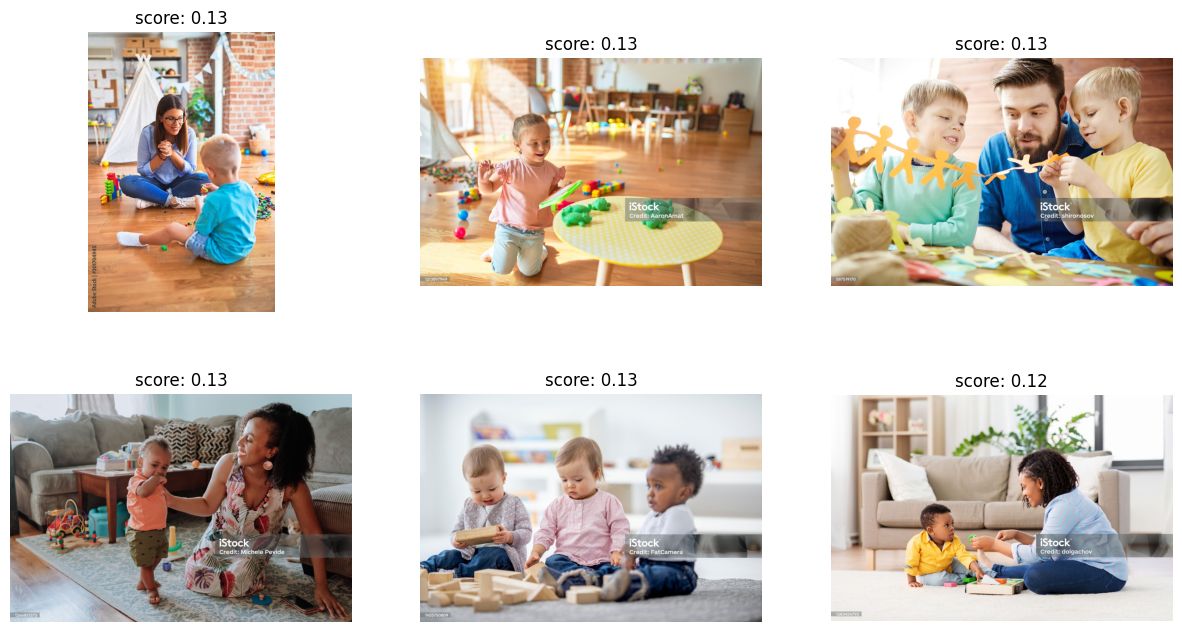

In [16]:
find_matches(model1,
             query=query_list[5],
             image_embeddings=image_embeddings1,
             image_filenames=img_names,
             size=(2, 3))